In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('/Users/huangwen/上课资料/智慧物流-订单规划/lesson3/课上数据/score_card/cs-training.csv')

In [2]:
df_train.drop('Unnamed: 0', inplace=True, axis=1)

In [3]:
df_train.info()
df_train.head()
df_train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [4]:
#查看下target SeriousDlqin2yrs的分布
#样本分布不均衡
import matplotlib.pyplot as plt
import seaborn as sns
temp = df_train['SeriousDlqin2yrs'].value_counts()
sns.barplot(x=temp.index, y=temp.values)
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('count')

Text(0,0.5,'count')

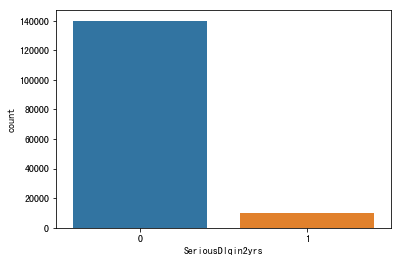

In [5]:
sns.countplot(x='SeriousDlqin2yrs', data=df_train)

In [6]:
df_train['SeriousDlqin2yrs'].sum()/len(df_train['SeriousDlqin2yrs'])

0.06684

In [7]:
for col in df_train.columns:
    print(df_train.describe()[col])

count    150000.000000
mean          0.066840
std           0.249746
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: SeriousDlqin2yrs, dtype: float64
count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64
count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64
count    150000.000000
mean          0.421033
std           4.192781
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64
count    150000.000000
mean        353.005076
std        2037.818523
min         

In [8]:
df_train.describe()['SeriousDlqin2yrs']

count    150000.000000
mean          0.066840
std           0.249746
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: SeriousDlqin2yrs, dtype: float64

### 处理缺失值，从上面可以看出MonthlyIncome，NumberOfDependents存在缺失值，这里打算通过随机森林的方式进行预测填充

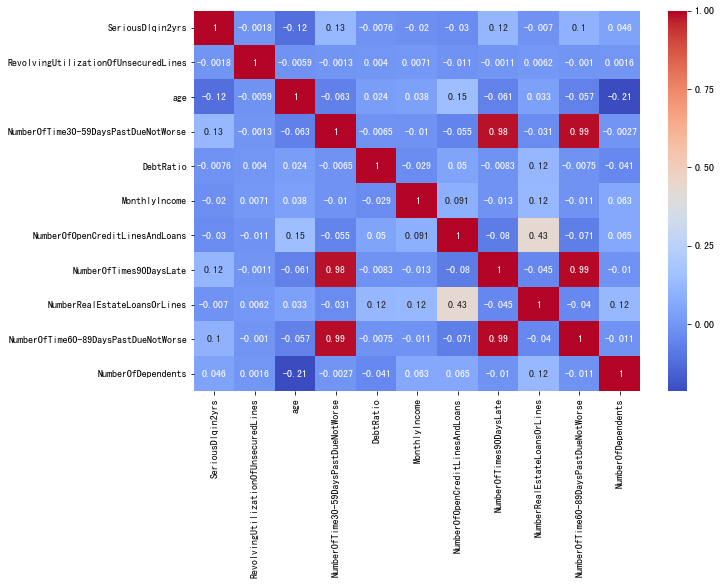

In [9]:
#先看下相关性
corr = df_train.corr()
fig = plt.figure(figsize=(10,7))
sns.heatmap(corr, cmap='coolwarm', annot=True)

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def regression_model_stats(model, x_train, x_test, y_train, y_test, name):
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    #pd.DataFrame({'hh':list(y_pred)}).to_csv('hh.csv')
    mae = mean_absolute_error(y_pred, y_test)
    mse= mean_squared_error(y_pred, y_test)
    rmse= mse ** 0.5
    r2 =r2_score(y_test, y_pred)
    print('Model used:' ,name)
    print('{} MAE:{}%' .format(name, mae))
    print('{} MSE:{}%'.format(name, mse))
    print('{} RMSE:{}'.format(name, rmse))
    print('{} R Squared:{}%'.format(name,r2))
    return mae, mse, rmse, r2

In [11]:
#预测填充MonthlyIncome
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

MonthlyIncomeTrain_y = df_train[(df_train['MonthlyIncome'].notnull()) & (df_train['MonthlyIncome'] > 10)]['MonthlyIncome'].copy()
MonthlyIncomeTrain_X =  df_train[df_train['MonthlyIncome'].notnull()  & (df_train['MonthlyIncome'] > 10)].drop(['NumberOfDependents','MonthlyIncome','SeriousDlqin2yrs'], axis=1)

MonthlyIncomeTest_X = df_train[(df_train['MonthlyIncome'].isnull()) | (df_train['MonthlyIncome'] <=10)].drop(['NumberOfDependents','MonthlyIncome','SeriousDlqin2yrs'], axis=1)
scaler = MinMaxScaler()
x_IM_train_scaler = scaler.fit_transform(MonthlyIncomeTrain_X)
x_IM_test_scaler = scaler.transform(MonthlyIncomeTest_X)

MI_train_x, MI_valid_x, MI_train_y, MI_valid_y = train_test_split(x_IM_train_scaler, MonthlyIncomeTrain_y, test_size=0.1)
#model = RandomForestRegressor(n_estimators=512,  max_depth=10)
#这里尝试了下xgboost
model = XGBRegressor(n_estimators=1000, learning_rate=0.1,  max_depth=7)
mae, mse, rmse, r2 =  regression_model_stats(model, MI_train_x, MI_valid_x, MI_train_y, MI_valid_y, 'RandomRorest')



[11:42:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model used: RandomRorest
RandomRorest MAE:2542.086380419257%
RandomRorest MSE:44278704.426523544%
RandomRorest RMSE:6654.2245548616365
RandomRorest R Squared:0.39747663267195643%


In [12]:
model.predict(x_IM_test_scaler)

array([ 685.2817 ,  108.13635,  303.33105, ..., 3887.0684 ,  675.5965 ,
       2804.774  ], dtype=float32)

In [13]:
#预测的效果好像并没有那么好，不过还是按照这个思路做
df_train.loc[(df_train['MonthlyIncome'].isnull()) | (df_train['MonthlyIncome'] <=10),'MonthlyIncome'] = model.predict(x_IM_test_scaler)

In [14]:
MonthlyIncomeTrain_X.columns
MonthlyIncomeTest_X.columns
#list(model.predict(x_IM_test_scaler))

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse'],
      dtype='object')

In [15]:
#填充NumberOfDependents
df_train['NumberOfDependents'].fillna(df_train['NumberOfDependents'].median(), inplace=True)

In [16]:
#df_train['NumberOfDependents']
df_train.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

# 数据进行分箱

In [17]:
import math
#对于age字段，分成6段 [-math.inf, 25, 40, 50, 60, 70, math.inf],自定义分箱
ages_bins= [-math.inf, 25, 40, 50, 60, 70, math.inf]
#df_train['age'].value_counts()
df_train['bin_age'] = pd.cut(df_train['age'], bins=ages_bins)
df_train[['age','bin_age']]

,age,bin_age
0,45,"(40.0, 50.0]"
1,40,"(25.0, 40.0]"
2,38,"(25.0, 40.0]"
3,30,"(25.0, 40.0]"
4,49,"(40.0, 50.0]"
...,...,...
149995,74,"(70.0, inf]"
149996,44,"(40.0, 50.0]"
149997,58,"(50.0, 60.0]"
149998,30,"(25.0, 40.0]"


In [18]:
#对于NumberOfDependents（家属人数）字段，分成6段[-math.inf,2,4,6,8,10,math.inf]
dependents_bins = [-math.inf,2,4,6,8,10,math.inf]
df_train['bin_NumberOfDependents'] = pd.cut(df_train['NumberOfDependents'],bins=dependents_bins)
df_train[['NumberOfDependents','bin_NumberOfDependents']].head()

,NumberOfDependents,bin_NumberOfDependents
0,2.0,"(-inf, 2.0]"
1,1.0,"(-inf, 2.0]"
2,0.0,"(-inf, 2.0]"
3,0.0,"(-inf, 2.0]"
4,0.0,"(-inf, 2.0]"


In [19]:
#对于3种逾期次数，即NumberOfTime30-59DaysPastDueNotWorse，NumberOfTime60-89DaysPastDueNotWorse，NumberOfTimes90DaysLate，分成10段
#[-math.inf,1,2,3,4,5,6,7,8,9,math.inf]
dpd_bins = [-math.inf,1,2,3,4,5,6,7,8,9,math.inf]
df_train['bin_NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime30-59DaysPastDueNotWorse'], bins=dpd_bins)
df_train['bin_NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime60-89DaysPastDueNotWorse'], bins=dpd_bins)
df_train['bin_NumberOfTimes90DaysLate'] = pd.cut(df_train['NumberOfTimes90DaysLate'], bins=dpd_bins)

In [20]:
#对于其余字段，即RevolvingUtilizationOfUnsecuredLines, 
#DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines 分成5段
df_train['bin_RevolvingUtilizationOfUnsecuredLines'] = pd.qcut(df_train['RevolvingUtilizationOfUnsecuredLines'], q=5, duplicates='drop')
df_train['bin_DebtRatio'] = pd.qcut(df_train['DebtRatio'], q=5, duplicates='drop')
df_train['bin_MonthlyIncome'] = pd.qcut(df_train['MonthlyIncome'], q=5, duplicates='drop')
df_train['bin_NumberOfOpenCreditLinesAndLoans'] = pd.qcut(df_train['NumberOfOpenCreditLinesAndLoans'], q=5, duplicates='drop')
df_train['bin_NumberRealEstateLoansOrLines'] = pd.qcut(df_train['NumberRealEstateLoansOrLines'], q=5, duplicates='drop')


In [21]:
bin_cols = [c for c in df_train.columns if c.startswith('bin_')]
bin_cols

['bin_age',
 'bin_NumberOfDependents',
 'bin_NumberOfTime30-59DaysPastDueNotWorse',
 'bin_NumberOfTime60-89DaysPastDueNotWorse',
 'bin_NumberOfTimes90DaysLate',
 'bin_RevolvingUtilizationOfUnsecuredLines',
 'bin_DebtRatio',
 'bin_MonthlyIncome',
 'bin_NumberOfOpenCreditLinesAndLoans',
 'bin_NumberRealEstateLoansOrLines']

In [22]:
#计算IV值， 衡量自变量的预测能力
def cal_IV(df, feature, target):
    cols = ['col','value','all','bad','good']
    base_list = []
    for val in df[feature].unique():
        count = df[df[feature] == val][feature].count()
        bad = df[(df[feature] == val ) & (df[target] == 1)][feature].count()
        good = df[(df[feature] == val ) & (df[target] == 0)][feature].count()
        base_list.append([feature, val , count, bad, good])
    data = pd.DataFrame(base_list, columns=cols)
    data['margin_bad_rate'] = data['bad']/data['bad'].sum()
    data.loc[data['margin_bad_rate']== 0, 'margin_bad_rate'] = 0.00001
    data['margin_good_rate'] = data['good']/data['good'].sum()
    #这个地方很奇怪，老师视频中没有出现在Rbin_NumberOfDependents下，会出现 log为0时的-inf的报警，untimeWarning: divide by zero encountered in log
    data['WOE'] = np.log(data['margin_bad_rate']/data['margin_good_rate']) 
    data['IV'] = (data['margin_bad_rate'] - data['margin_good_rate'])*data['WOE']
    #print(data)
    print(feature, data['IV'].sum())
    return data['IV'].sum()

In [23]:
# 里面数据的确有问题，所以这里要处理下为0的情况
df_train[df_train['NumberOfDependents'] >=10][['NumberOfDependents','SeriousDlqin2yrs']]

,NumberOfDependents,SeriousDlqin2yrs
6299,20.0,0
10618,10.0,0
12982,10.0,0
22698,10.0,0
39095,10.0,0
123911,10.0,0
128034,13.0,0


In [24]:
#cal_IV(df_train, 'bin_NumberOfDependents', 'SeriousDlqin2yrs')
#筛选出大于IV>0.1的col
select_bin_col=[]
for col in bin_cols:
    IV = cal_IV(df_train, col, 'SeriousDlqin2yrs')
    if IV>=0.1:
        select_bin_col.append(col)

bin_age 0.24041120302785982
bin_NumberOfDependents 0.01463012170541098
bin_NumberOfTime30-59DaysPastDueNotWorse 0.492444774570198
bin_NumberOfTime60-89DaysPastDueNotWorse 0.26655914618929066
bin_NumberOfTimes90DaysLate 0.49160685733515563
bin_RevolvingUtilizationOfUnsecuredLines 1.0596188771423887
bin_DebtRatio 0.05948761145809681
bin_MonthlyIncome 0.057065541435913233
bin_NumberOfOpenCreditLinesAndLoans 0.04802315528985505
bin_NumberRealEstateLoansOrLines 0.0120914141106244


In [26]:
select_bin_col

['bin_age',
 'bin_NumberOfTime30-59DaysPastDueNotWorse',
 'bin_NumberOfTime60-89DaysPastDueNotWorse',
 'bin_NumberOfTimes90DaysLate',
 'bin_RevolvingUtilizationOfUnsecuredLines']

In [63]:
df_bin_to_woe=pd.DataFrame(columns=['feature','bin','woe'])
def cal_WOE(df, feature, target):
    global df_bin_to_woe
    df_woe = df.groupby([feature]).agg({target:['sum','count']})
    df_woe.columns = list(map(''.join, df_woe.columns.values))
    df_woe = df_woe.reset_index()
    df_woe = df_woe.rename(columns={target+'sum':'bad', target+'count':'all'})
    #计算WOE
    #print(df_woe)
    df_woe['good_rate'] = (df_woe['all'] - df_woe['bad'])/(df_woe['all'].sum() - df_woe['bad'].sum())
    df_woe['bad_rate'] = df_woe['bad']/df_woe['bad'].sum()
    df_woe.loc[df_woe['bad_rate']== 0, 'bad_rate'] = 0.00001
    df_woe[feature+'_WOE'] = np.log(df_woe['bad_rate']/df_woe['good_rate'])
    df =df.merge(df_woe[[feature, feature+'_WOE']], on=feature, how='left')
    df_woe['feature'] = feature.split('_')[1]
    temp = df_woe[['feature',feature,feature+'_WOE']].rename(columns={feature:'bin',feature+'_WOE':'woe'})
    df_bin_to_woe= df_bin_to_woe.append(temp)
    print(df_woe)
    return df

In [64]:
df_train_new = df_train.copy()
#df_train_new = cal_WOE(df_train, 'bin_age','SeriousDlqin2yrs')
for col in select_bin_col:
    df_train_new = cal_WOE(df_train_new, col,'SeriousDlqin2yrs')

        bin_age   bad    all  good_rate  bad_rate  bin_age_WOE feature
0  (-inf, 25.0]   338   3028   0.019218  0.033712     0.562024     age
1  (25.0, 40.0]  3296  32069   0.205560  0.328745     0.469547     age
2  (40.0, 50.0]  2893  35037   0.229643  0.288550     0.228343     age
3  (50.0, 60.0]  2149  34806   0.233308  0.214343    -0.084782     age
4  (60.0, 70.0]   952  27424   0.189121  0.094953    -0.689003     age
5   (70.0, inf]   398  17636   0.123151  0.039697    -1.132145     age
  bin_NumberOfTime30-59DaysPastDueNotWorse   bad     all  good_rate  bad_rate  \
0                              (-inf, 1.0]  7450  142051   0.961614  0.743068   
1                               (1.0, 2.0]  1219    4598   0.024140  0.121584   
2                               (2.0, 3.0]   618    1754   0.008116  0.061640   
3                               (3.0, 4.0]   318     747   0.003065  0.031718   
4                               (4.0, 5.0]   154     342   0.001343  0.015360   
5                

In [31]:
df_train_new.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'bin_age', 'bin_NumberOfDependents',
       'bin_NumberOfTime30-59DaysPastDueNotWorse',
       'bin_NumberOfTime60-89DaysPastDueNotWorse',
       'bin_NumberOfTimes90DaysLate',
       'bin_RevolvingUtilizationOfUnsecuredLines', 'bin_DebtRatio',
       'bin_MonthlyIncome', 'bin_NumberOfOpenCreditLinesAndLoans',
       'bin_NumberRealEstateLoansOrLines', 'bin_age_WOE',
       'bin_NumberOfTime30-59DaysPastDueNotWorse_WOE',
       'bin_NumberOfTime60-89DaysPastDueNotWorse_WOE',
       'bin_NumberOfTimes90DaysLate_WOE',
       'bin_RevolvingUtilizationOfUnsecuredLines_WOE'],
      dtype='object')

In [65]:
#得到WOE规则
df_bin_to_woe

,feature,bin,woe
0,age,"(-inf, 25.0]",0.562024
1,age,"(25.0, 40.0]",0.469547
2,age,"(40.0, 50.0]",0.228343
3,age,"(50.0, 60.0]",-0.084782
4,age,"(60.0, 70.0]",-0.689003
5,age,"(70.0, inf]",-1.132145
0,NumberOfTime30-59DaysPastDueNotWorse,"(-inf, 1.0]",-0.257826
1,NumberOfTime30-59DaysPastDueNotWorse,"(1.0, 2.0]",1.616726
2,NumberOfTime30-59DaysPastDueNotWorse,"(2.0, 3.0]",2.027495
3,NumberOfTime30-59DaysPastDueNotWorse,"(3.0, 4.0]",2.336869


In [73]:
woe_col = [ i+'_WOE' for i in select_bin_col ]
woe_col
df_train_new[woe_col]

,bin_age_WOE,bin_NumberOfTime30-59DaysPastDueNotWorse_WOE,bin_NumberOfTime60-89DaysPastDueNotWorse_WOE,bin_NumberOfTimes90DaysLate_WOE,bin_RevolvingUtilizationOfUnsecuredLines_WOE
0,0.228343,1.616726,-0.09799,-0.176674,1.242254
1,0.469547,-0.257826,-0.09799,-0.176674,1.242254
2,0.469547,-0.257826,-0.09799,-0.176674,0.053164
3,0.469547,-0.257826,-0.09799,-0.176674,-0.866502
4,0.228343,-0.257826,-0.09799,-0.176674,1.242254
...,...,...,...,...,...
149995,-1.132145,-0.257826,-0.09799,-0.176674,-1.447382
149996,0.228343,-0.257826,-0.09799,-0.176674,0.053164
149997,-0.084782,-0.257826,-0.09799,-0.176674,-0.866502
149998,0.469547,-0.257826,-0.09799,-0.176674,-1.286617


逻辑回归建模


In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_new[woe_col], df_train_new['SeriousDlqin2yrs'], test_size=0.2, random_state=33)

In [86]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score
def classification_model_stats(model, x_train, x_test, y_train, y_test, name):
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(y_pred)
    accuracy = accuracy_score(y_pred, y_test)
    recall= recall_score(y_pred, y_test)
    confusion= confusion_matrix(y_test, y_pred)
    f1 =f1_score(y_test, y_pred)
    print('Model used:' ,name)
    print('{} Accuracy:{}%' .format(name, accuracy*100))
    print('{} recall:{}%'.format(name, recall*100))
    print('{} Confusion Matrix:\n{}'.format(name, confusion))
    print('{} F1 score:{}%'.format(name, f1*100))
    return accuracy, recall, f1, y_pred

In [89]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=33, class_weight='balanced')
acc, recall, f1, y_pred = classification_model_stats(model, X_train, X_test, y_train, y_test, 'LogisticRegression')

[0 1 1 ... 0 0 0]
Model used: LogisticRegression
LogisticRegression Accuracy:79.93666666666667%
LogisticRegression recall:20.708764765932624%
LogisticRegression Confusion Matrix:
[[22561  5437]
 [  582  1420]]
LogisticRegression F1 score:32.05779433344622%


In [104]:
from sklearn.model_selection import cross_val_score
model = LogisticRegression(random_state=33, class_weight='balanced')
print('f1.score', cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean())
print('accuracy .score', cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean())


f1.score 0.3121263802899779
accuracy .score 0.7959749870115596


In [108]:
def lr_cv(max_iter, C):
    result = cross_val_score(LogisticRegression(C=C, class_weight='balanced',max_iter=max_iter), X_train, y_train, cv=5, scoring='f1').mean()
    return result
#贝叶斯优化
from bayes_opt import BayesianOptimization
lr_op = BayesianOptimization(f= lr_cv, pbounds={'C':(0.01,10), 'max_iter':(50,500)})
lr_op.maximize()
print(lr_op.max)

|   iter    |  target   |     C     | max_iter  |
-------------------------------------------------
|  1        |  0.3121   |  6.132    |  291.6    |
|  2        |  0.3121   |  3.231    |  161.5    |
|  3        |  0.3121   |  0.2579   |  471.0    |
|  4        |  0.3121   |  0.6143   |  154.3    |
|  5        |  0.3121   |  9.833    |  400.8    |
|  6        |  0.3121   |  9.876    |  50.21    |
|  7        |  0.3121   |  9.655    |  499.9    |
|  8        |  0.3121   |  8.821    |  50.2     |
|  9        |  0.3121   |  1.086    |  499.9    |
|  10       |  0.3121   |  1.089    |  50.02    |
|  11       |  0.3121   |  9.68     |  499.5    |
|  12       |  0.3121   |  0.2916   |  50.17    |
|  13       |  0.3121   |  0.5231   |  500.0    |
|  14       |  0.3121   |  9.685    |  51.01    |
|  15       |  0.3121   |  9.223    |  499.7    |
|  16       |  0.3121   |  9.915    |  50.59    |
|  17       |  0.3127   |  0.03623  |  499.6    |
|  18       |  0.3121   |  0.1117   |  499.5    |


In [111]:
model = LogisticRegression(class_weight='balanced',C=0.0362, max_iter=500)
acc, recall, f1, y_pred = classification_model_stats(model, X_train, X_test, y_train, y_test, 'LogisticRegression')

[0 1 1 ... 0 0 0]
Model used: LogisticRegression
LogisticRegression Accuracy:79.93666666666667%
LogisticRegression recall:20.708764765932624%
LogisticRegression Confusion Matrix:
[[22561  5437]
 [  582  1420]]
LogisticRegression F1 score:32.05779433344622%


In [ ]:
woe里的逻辑回归系数为正数， B为正数

In [141]:
#A = P0 + B*ln(θ) P0基线， PDO翻倍
#B= PDO/ln(2)
PDO=50
P0 = 600
θ = df_train['SeriousDlqin2yrs'].sum()/len(df_train['SeriousDlqin2yrs'])
B=50/np.log(2)
A = P0 + B *(np.log(θ))
print('A:',A)
print('B:',B)

A: 404.8427771812188
B: 72.13475204444818


In [127]:
def generate_scorecard(model_coef, binning_df, features, B):
    lst= []
    cols = ['Variable', 'Binning', 'Score']
    coef = model_coef[0]
    for i in range(len(features)):
        f = features[i]
        df = binning_df[binning_df['feature'] == f]
        df.apply(lambda x: lst.append([f, x['bin'], int(round(-coef[i]*x['woe']*B))]),axis=1)
    data = pd.DataFrame(lst, columns=cols)
    return data


In [270]:
score_card = generate_scorecard(model.coef_, df_bin_to_woe, [i.split('_')[1] for i in select_bin_col], B)


In [264]:
score_card['Score']  = score_card['Score'] - score_card['Score'].min()

In [265]:
sort_card = score_card.groupby('Variable').apply(lambda x:x.sort_values('Score', ascending=False))
sort_card

Variable  \
Variable                                                                        
NumberOfTime30-59DaysPastDueNotWorse 6   NumberOfTime30-59DaysPastDueNotWorse   
                                     7   NumberOfTime30-59DaysPastDueNotWorse   
                                     13  NumberOfTime30-59DaysPastDueNotWorse   
                                     14  NumberOfTime30-59DaysPastDueNotWorse   
                                     8   NumberOfTime30-59DaysPastDueNotWorse   
                                     9   NumberOfTime30-59DaysPastDueNotWorse   
                                     10  NumberOfTime30-59DaysPastDueNotWorse   
                                     12  NumberOfTime30-59DaysPastDueNotWorse   
                                     11  NumberOfTime30-59DaysPastDueNotWorse   
                                     15  NumberOfTime30-59DaysPastDueNotWorse   
NumberOfTime60-89DaysPastDueNotWorse 16  NumberOfTime60-89DaysPastDueNotWorse   
                                     24  NumberOfTime60-89DaysPastDueNotWorse   
                                     23  NumberOfTime60-89DaysPastDueNotWorse   
                                     17  NumberOfTime60-89DaysPastDueNotWorse   
                                     25  NumberOfTime60-89DaysPastDueNotWorse   
                                     22  NumberOfTime60-89DaysPastDueNotWorse   
                                     18  NumberOfTime60-89DaysPastDueNotWorse   
                                     19  NumberOfTime60-89DaysPastDueNotWorse   
                                     20  NumberOfTime60-89DaysPastDueNotWorse   
                                     21  NumberOfTime60-89DaysPastDueNotWorse   
NumberOfTimes90DaysLate              26               NumberOfTimes90DaysLate   
                                     27               NumberOfTimes90DaysLate   
                                     35               NumberOfTimes90DaysLate   
                                     28               NumberOfTimes90DaysLate   
                                     31               NumberOfTimes90DaysLate   
                                     30               NumberOfTimes90DaysLate   
                                     29               NumberOfTimes90DaysLate   
                                     33               NumberOfTimes90DaysLate   
                                     34               NumberOfTimes90DaysLate   
                                     32               NumberOfTimes90DaysLate   
RevolvingUtilizationOfUnsecuredLines 37  RevolvingUtilizationOfUnsecuredLines   
                                     36  RevolvingUtilizationOfUnsecuredLines   
                                     38  RevolvingUtilizationOfUnsecuredLines   
                                     39  RevolvingUtilizationOfUnsecuredLines   
                                     40  RevolvingUtilizationOfUnsecuredLines   
age                                  5                                    age   
                                     4                                    age   
                                     3                                    age   
                                     2                                    age   
                                     1                                    age   
                                     0                                    age   

                                                  Binning  Score  
Variable                                                          
NumberOfTime30-59DaysPastDueNotWorse 6        (-inf, 1.0]    207  
                                     7         (1.0, 2.0]    110  
                                     13        (7.0, 8.0]     97  
                                     14        (8.0, 9.0]     93  
                                     8         (2.0, 3.0]     89  
                                     9         (3.0, 4.0]     73  
                                     10        (4

In [266]:
 feature_binning_score = score_card.groupby(['Variable','Binning'])['Score'].apply(lambda x: int(x)).to_dict()

In [267]:
def woe_map_score(x):
    print(x.values)
    feature = x.name.split('_')[1]
    #print(feature)
    print(x.apply(lambda y : feature_binning_score[(feature, y)]).values)
    return x.apply(lambda y : feature_binning_score[(feature, y)])


In [268]:
#df_train_new['score'] = df_train_new.loc[:1, select_bin_col].apply(woe_map_score).apply(lambda x: A+sum(x),axis=1)
df_score = df_train_new.loc[:1, select_bin_col].apply(woe_map_score).apply(lambda x: A+sum(x),axis=1)
df_score

[(40.0, 50.0], (25.0, 40.0]]
Categories (6, interval[float64]): [(-inf, 25.0] < (25.0, 40.0] < (40.0, 50.0] < (50.0, 60.0] < (60.0, 70.0] < (70.0, inf]]
[185, 176]
Categories (6, int64): [173 < 176 < 185 < 197 < 220 < 236]
[(1.0, 2.0], (-inf, 1.0]]
Categories (10, interval[float64]): [(-inf, 1.0] < (1.0, 2.0] < (2.0, 3.0] < (3.0, 4.0] ... (6.0, 7.0] < (7.0, 8.0] < (8.0, 9.0] < (9.0, inf]]
[110, 207]
Categories (10, int64): [207 < 110 < 89 < 73 ... 54 < 97 < 93 < 47]
[(-inf, 1.0], (-inf, 1.0]]
Categories (10, interval[float64]): [(-inf, 1.0] < (1.0, 2.0] < (2.0, 3.0] < (3.0, 4.0] ... (6.0, 7.0] < (7.0, 8.0] < (8.0, 9.0] < (9.0, inf]]
[198 198]
[(-inf, 1.0], (-inf, 1.0]]
Categories (10, interval[float64]): [(-inf, 1.0] < (1.0, 2.0] < (2.0, 3.0] < (3.0, 4.0] ... (6.0, 7.0] < (7.0, 8.0] < (8.0, 9.0] < (9.0, inf]]
[202, 202]
Categories (10, int64): [202 < 70 < 56 < 37 ... 0 < 27 < 22 < 62]
[(0.699, 50708.0], (0.699, 50708.0]]
Categories (5, interval[float64]): [(-0.001, 0.0192] < (0.0192, 0

0    1223.842777
1    1311.842777
dtype: float64

In [269]:
df_score = df_train_new[df_train_new['SeriousDlqin2yrs'] ==0 ].sample(5)[select_bin_col].apply(woe_map_score).apply(lambda x: A+sum(x),axis=1)
df_score

[(50.0, 60.0], (25.0, 40.0], (50.0, 60.0], (25.0, 40.0], (60.0, 70.0]]
Categories (6, interval[float64]): [(-inf, 25.0] < (25.0, 40.0] < (40.0, 50.0] < (50.0, 60.0] < (60.0, 70.0] < (70.0, inf]]
[197, 176, 197, 176, 220]
Categories (6, int64): [173 < 176 < 185 < 197 < 220 < 236]
[(-inf, 1.0], (-inf, 1.0], (-inf, 1.0], (-inf, 1.0], (-inf, 1.0]]
Categories (10, interval[float64]): [(-inf, 1.0] < (1.0, 2.0] < (2.0, 3.0] < (3.0, 4.0] ... (6.0, 7.0] < (7.0, 8.0] < (8.0, 9.0] < (9.0, inf]]
[207, 207, 207, 207, 207]
Categories (10, int64): [207 < 110 < 89 < 73 ... 54 < 97 < 93 < 47]
[(-inf, 1.0], (-inf, 1.0], (-inf, 1.0], (-inf, 1.0], (-inf, 1.0]]
Categories (10, interval[float64]): [(-inf, 1.0] < (1.0, 2.0] < (2.0, 3.0] < (3.0, 4.0] ... (6.0, 7.0] < (7.0, 8.0] < (8.0, 9.0] < (9.0, inf]]
[198 198 198 198 198]
[(-inf, 1.0], (-inf, 1.0], (-inf, 1.0], (-inf, 1.0], (-inf, 1.0]]
Categories (10, interval[float64]): [(-inf, 1.0] < (1.0, 2.0] < (2.0, 3.0] < (3.0, 4.0] ... (6.0, 7.0] < (7.0, 8.0] < (8

74714     1474.842777
4770      1430.842777
148853    1451.842777
62108     1462.842777
58782     1506.842777
dtype: float64